In [144]:
%matplotlib inline
#인풋아웃풋은 numpy
import matplotlib.pyplot as plt
import numpy as np
import math
from tensorflow.keras.models import load_model, Sequential, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from collections import Counter
import pandas as pd
from tensorflow.keras.callbacks import Callback
from datetime import datetime, timezone
from sklearn.model_selection import train_test_split
from tensorflow.keras import optimizers

#### data load
- (train data) X_train : 60000, 28x28
- (train data) Y_train : 60000, str
- (test data) X_test : 10000, 28x28
- (test data) Y_test : 10000, str


In [145]:
from tensorflow.keras.datasets import mnist

(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
X_test


array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

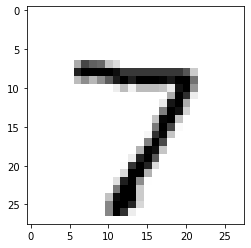

In [112]:
plt.imshow(X_test[0], cmap='binary')

#### convert and ready to data
* input image reshape
* output Y one hot encoding

In [147]:
X_train = X_train.reshape(60000, 28,28,1)
X_test = X_test.reshape(10000, 28,28,1)
X_train = X_train/255.0
X_test = X_test/255.0

Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

#### 예제 TEST용 경량 Model생성

In [152]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(5,5), padding='same', strides=1, activation='relu', input_shape=(28,28,1,), name='block1_conv1'))
model.add(MaxPool2D(pool_size=(2,2), name='block1_pool'))
model.add(Conv2D(filters=36, kernel_size=(5,5), padding='same', strides=1, activation='relu', name='block2_conv1'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax')) #최종은 항상 클래스 종류의 개수 
model.summary()

          


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 28, 28, 16)        416       
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 14, 14, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 14, 14, 36)        14436     
_________________________________________________________________
flatten_3 (Flatten)          (None, 7056)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               903296    
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1290      
Total params: 919,438
Trainable params: 919,438
Non-trainable params: 0
________________________________________________

#### Error function 

In [115]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#### taining

In [116]:
hist = model.fit(X_train, Y_train, batch_size=200, epochs=1, validation_split=0.2)

240/240 [==============================] - 15s 62ms/step - loss: 0.2404 - accuracy: 0.9287 - val_loss: 0.0726 - val_accuracy: 0.9777


#### evaluate

In [117]:
score = model.evaluate(X_test, Y_test)
score

313/313 [==============================] - 1s 4ms/step - loss: 0.0654 - accuracy: 0.9790


[0.06544948369264603, 0.9789999723434448]

#### layer확인

In [120]:
'''
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
conv2d_4 (Conv2D)            (None, 28, 28, 16)        416       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 36)        14436     
_________________________________________________________________
flatten_2 (Flatten)          (None, 7056)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               903296    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
=================================================================
'''
l1 = model.get_layer('conv2d_4')
l1.get_weights()
l1.get_weights()[0].shape #(5,5,1,16) -> kernel 16개 

(5, 5, 1, 16)

In [121]:
def plot_weight(w):
    w_min = np.min(w)
    w_max = np.max(w)
    
    num_grid = math.ceil(math.sqrt(w.shape[3]))
    fix, aixs = plt.subplots(num_grid, num_grid)
    
    for i, ax in enumerate(aixs.flat):
        if i < w.shape[3]:
            img = w[:,:,0,i]
            ax.imshow(img, vmin=w_min, vmax=w_max)
            
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()
            
                        

#### CNN layer kernel확인

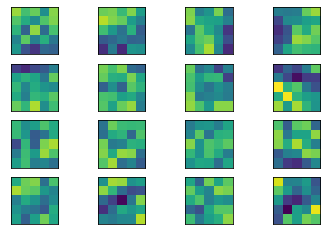

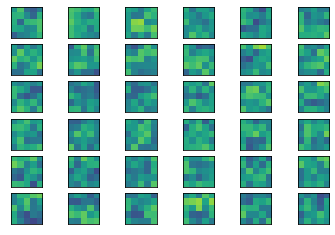

In [123]:
l1 = model.get_layer('conv2d_4')
w1 = l1.get_weights()[0]

plot_weight(w1)

l2 = model.get_layer('conv2d_5')
w2 = l2.get_weights()[0]

plot_weight(w2)

In [134]:
# 이런 conv2 첫번째 레이어를 통과한 결과 kernel 로 테스트 데이터를 predict하는 방법

temp_model = Model(inputs=model.get_layer('conv2d_4').input, outputs=model.get_layer('conv2d_4').output)
output = temp_model.predict(X_test)
output.shape


(10000, 28, 28, 16)

In [135]:
#(10000, 24, 24, 16) 두번째만 출력
def plot_temp_output(output):
        
    num_grid = math.ceil(math.sqrt(output.shape[3]))
    fix, aixs = plt.subplots(num_grid, num_grid)
    
    for i, ax in enumerate(aixs.flat):
        if i < output.shape[3]:
            img = output[0,:,:,i]
            ax.imshow(img, cmap='binary')
            
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

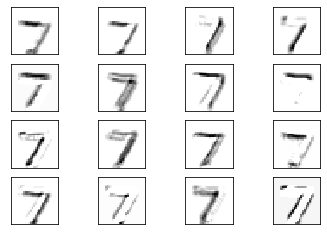

In [136]:
#첫번째 레이어의 출력 gradient영상예
plot_temp_output(output)